**Solving Sudoku Puzzle Using Pytesseract and Pysudoku**

The **classic sudoku** is a number placing puzzle game with a grid of **9 rows and 9 columns**, partly filled with **numbers 1..9** . We have to fill up the remaining positions such that each **row, columns and 3x3 sub grids** contains numbers 1..9, **without any repeatation**.

Here our **input** is an **image of sudoku** puzzle and we need to produce a corresponding **output image** by filling the remaining positions of the input with **valid** digits. The pipeline for the **solution** consists of the following steps.

* Preprocess the input image and remove the background
* Crop subregions containing digits from the grid
* Predict numbers from image crops using pytesseract ocr
* Predict the solution using py-sudoku module
* Plot the resuts on the input image

In [ ]:
# Install pysudoku and pytesseract
!sudo pip install py-sudoku
!sudo add-apt-repository ppa:alex-p/tesseract-ocr
!sudo apt-get update
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!sudo pip install pytesseract
!wget -N https://github.com/tesseract-ocr/tessdata/raw/master/eng.traineddata --directory-prefix=/usr/share/tesseract-ocr/4.00/tessdata/

In [2]:
# Imports and libraries
import os,cv2
import numpy as np
import imutils
import pytesseract
from sudoku import Sudoku

import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from imutils.perspective import four_point_transform

**Preprocess And Remove Background**

Crop, transform and save the **smallest square** region containing the **puzzle**

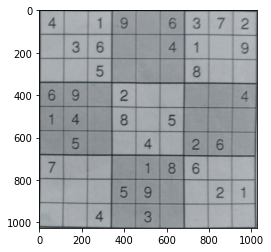

In [3]:
# Read the input sudoku image 
img =  cv2.imread("test_onestar_1.jpg")

# Preprocess the input image and apply adaptive thresholding
img = cv2.resize(img,(1026,1026))
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgray =  cv2.GaussianBlur(imgray,(11,11),0)
thresh = cv2.adaptiveThreshold(imgray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,5,2)

# Connect the broken grid lines on the threshold image using dilation
kernel = np.array([0,1,0,1,1,1,0,1,0],dtype=np.uint8).reshape(3,3)
thresh = cv2.dilate(thresh, kernel,iterations = 2)
cv2.imwrite('thresh.jpg', thresh)

# Find contours in the thresholded image and sort them by size in descending order
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

# Find the largest quadrilateral contour with the help of polygonal approximation
puzz_cntr = None
for c in cnts:
  peri = cv2.arcLength(c, True)
  approx = cv2.approxPolyDP(c, 0.1 * peri, True)

  if len(approx) == 4:
    puzz_cntr = approx
    break

# Apply four point perspective transform and get the warped images
out_gry=four_point_transform(img, puzz_cntr.reshape(4, 2))
out_bin=four_point_transform(thresh, puzz_cntr.reshape(4, 2))

# Dilate the image to fill the cracks
kernel = np.array([0,1,0,1,1,1,0,1,0],dtype=np.uint8).reshape(3,3)
out_bin = cv2.dilate(out_bin, kernel,iterations = 1)

# Resize the binary and grayscale images
out_bin=cv2.resize(out_bin,(1026,1026))
out_gry=cv2.resize(out_gry,(1026,1026))

# Save the binary and grayscale outputs
cv2.imwrite('puzzle.jpg', out_gry)
cv2.imwrite('puzzle_bin.jpg', out_bin)

# Show the grayscale output image
plt.imshow(out_gry)

**Crop ROI Cells**

Here, we only use the previous **cropped grayscale image** for further processing.

* Divide the images into **9 rows and 9 columns** roughly along the grid patterns, such that each **cell** containig the digits have **same size**.

* For each such cell in the image we apply apply **automatic thresholding** with the help of **otsu binarization**.
* Now, we need to **clear** all the unncesaary **connected border lines** that touch the cell borders.
* Finally, **save** these entire batch(81) of images as **numpy array**, in order and **plot** the results.

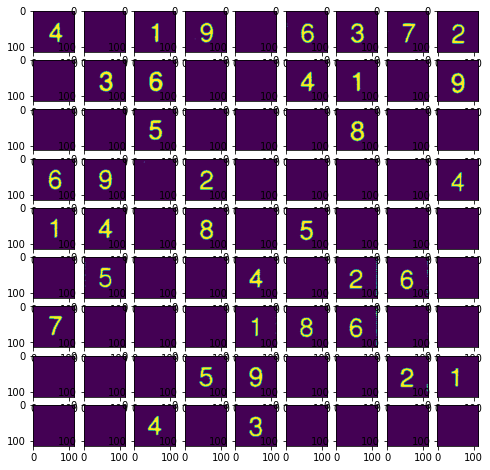

In [4]:
# Get cell size for square blocks
imgheight=out_bin.shape[0]
imgwidth=out_bin.shape[1]
H,W = imgheight//9, imgwidth//9

# For each cell, crop the roi and append to list
sudokus=[]
for y in range(0,imgheight,H):
    for x in range(0, imgwidth, W):
        y1 = y + H
        x1 = x + W
        cell_gry = cv2.cvtColor(out_gry[y:y+H,x:x+W], cv2.COLOR_BGR2GRAY)
        cell_thresh = cv2.threshold(cell_gry, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        cell_thresh = clear_border(cell_thresh)                                                                   
        
        sudokus.append(cell_thresh)

# Create a numpy array with 81 images from list
sudoku_images=np.uint8(sudokus)

# Plot the images using matplotlib
fig=plt.figure(figsize=(8, 8))
columns = 9
rows = 9
for i in range(1, columns*rows +1):
    img = sudoku_images[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze())
plt.show()

**Extract Digits And Perform OCR** 

* Initially crop the **smallest square** containing the digits from their cells, using **contour area** as filter.
* If the ROI regions are **blank spaces** representing unfilled positions, we return an **empty array** to represent the **digit zero**.
* Now, perform **ocr** using pytesseract, on each **cell roi's** and save all the results as **numpy array**.

In [5]:
def crop_center(crop_bin):
   
   # Find contours in the binary image
   contours, _ = cv2.findContours(crop_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

   # Check for blanks in the image
   if len(contours) == 0 or cv2.contourArea( max(contours, key = cv2.contourArea))<250:
     return np.empty(0)

   # Get contour with maximum area
   cnt = max(contours, key = cv2.contourArea)
   x,y,w,h = cv2.boundingRect(cnt)

   # Crop the smallest square roi with digits
   d=(h-w)//2
   c=crop_bin.shape[0]
   roi = crop_bin[y:y+h, max(0,x-d):min(c,x+w+d)]
   
   return roi


# Perform ocr on single character, for all roi cells
numbers=[]
for i in range(0,81):
   roi=crop_center(sudoku_images[i])
   if roi.size > 0 :
     ocr_result=pytesseract.image_to_string(roi, config='--psm 10 --oem 0  -c tessedit_char_whitelist=123456789')
     numbers.append(int(ocr_result[0]))     
   else:
     numbers.append(0)

# Save the result as numpy array
sudoku_numbers=np.uint8(numbers).reshape((9,9))

print(sudoku_numbers)

[[4 0 1 9 0 6 3 7 2]
 [0 3 6 0 0 4 1 0 9]
 [0 0 5 0 0 0 8 0 0]
 [6 9 0 2 0 0 0 0 4]
 [1 4 0 8 0 5 0 0 0]
 [0 5 0 0 4 0 2 6 0]
 [7 0 0 0 1 8 6 0 0]
 [0 0 0 5 9 0 0 2 1]
 [0 0 4 0 3 0 0 0 0]]


**Solve Puzzle With Py-sudoku**

* Convert the numpy array to **list** and call the **sudoku solver**
* Print the **input and output** results in **text format**

In [7]:
# Solve the sudoku puzzle using py-sudoku
puzzle = Sudoku(3, 3, board=sudoku_numbers.tolist())
print(puzzle)

result = puzzle.solve()
result.show_full()


---------------------------
9x9 (3x3) SUDOKU PUZZLE
Difficulty: 0.56
---------------------------
+-------+-------+-------+
| 4   1 | 9   6 | 3 7 2 |
|   3 6 |     4 | 1   9 |
|     5 |       | 8     |
+-------+-------+-------+
| 6 9   | 2     |     4 |
| 1 4   | 8   5 |       |
|   5   |   4   | 2 6   |
+-------+-------+-------+
| 7     |   1 8 | 6     |
|       | 5 9   |   2 1 |
|     4 |   3   |       |
+-------+-------+-------+

        

---------------------------
9x9 (3x3) SUDOKU PUZZLE
Difficulty: SOLVED
---------------------------
+-------+-------+-------+
| 4 8 1 | 9 5 6 | 3 7 2 |
| 2 3 6 | 7 8 4 | 1 5 9 |
| 9 7 5 | 3 2 1 | 8 4 6 |
+-------+-------+-------+
| 6 9 8 | 2 7 3 | 5 1 4 |
| 1 4 2 | 8 6 5 | 7 9 3 |
| 3 5 7 | 1 4 9 | 2 6 8 |
+-------+-------+-------+
| 7 2 9 | 4 1 8 | 6 3 5 |
| 8 6 3 | 5 9 7 | 4 2 1 |
| 5 1 4 | 6 3 2 | 9 8 7 |
+-------+-------+-------+

        


**Plot Solution On Image**

Plot the **digits** from solution in their corresponding unfilled positions on the **input image**.

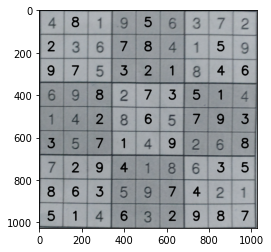

In [8]:
# Input and output results
puzzle=sudoku_numbers.copy()
solution=np.array(result.board)
sudoku=out_gry.copy()

# Plot the results over the original image
def show_output(puzzle, solution, sudoku):

  for i in range(9):
    for j in range(9):
      pos=(37+114*j, 77+114*i)
      if puzzle[i,j] == 0:
        cv2.putText(sudoku,str(solution[i,j]),pos, cv2.FONT_HERSHEY_SIMPLEX, 2, 0,5)

  plt.imshow(sudoku)

show_output(puzzle,solution,sudoku)